# NE 630 - Lesson 24

**LAST TIME**: fuel depletion, burnup, and the impact on reactivity

**TODAY**: the LRM!

# Review: Reactivity as a Function of Time/Fluence/Burnup

Last time, we computed $\rho$ as a function of fluence using the simplified U/Pu model, and it looked something like this (after adjusting the flux to obtain a proper initial power)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
ϕ = 2e14
σ235a = 57.20388 ;  σ235f = 46.88856
σ238a = 1.02191 ;   σ238f = 0.10507 
σ239a = 195.10020;  σ239f = 124.41051 
σB10a = 0.2*3409; # assuming a fast-to-thermal ratio of 4
N_a = 6.022e23
N_238_0 = 0.96*(238/(238+2*16))*N_a/238
N_235_0 = 0.04*(238/(238+2*16))*N_a/235
N_235 = lambda t: N_235_0 * np.exp(-σ235a*1e-24*ϕ*t)
σ238g = σ238a - σ238f
N_239 = lambda t: (σ238g/σ239a)*N_238_0*(1 - np.exp(-σ239a*1e-24*ϕ*t))
N_B10_0 = N_235_0*0.00
N_B10 = lambda t: N_B10_0 * np.exp(-σB10a*1e-24*ϕ*t)

In [2]:
σ235aT = 297.40444 ;  σ235fT =  253.08847 
σ238aT = 1.32087   ;  σ238fT =  0.00000 
σ239aT = 1146.51259;  σ239fT =  732.21983 
σB10aT = 3409; 
ς = 1.1; p=0.6; Ɛ = 1.3; P_NL = 0.95; ν=2.5; Σa_mT = 0.007

def k(t):
    return ((ν*σ235fT*N_235(t) + ν*σ239fT*N_239(t))*Ɛ*p*P_NL) /       \
    (σ235aT*N_235(t) + σ239aT*N_239(t) + σ238aT*N_238_0 + σB10aT*N_B10(t) + ς*Σa_mT)

def rho(t):
    return (k(t)-1)/k(t)

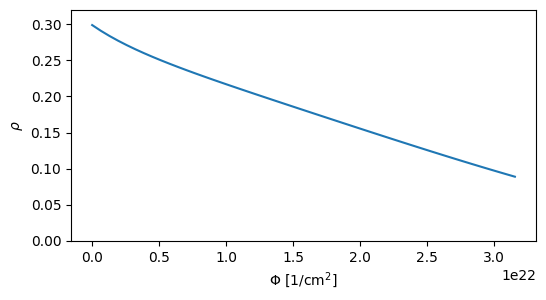

In [3]:
times = np.linspace(0, 5*365*24*3600)
fluence = ϕ*times
plt.figure(figsize=(6,3))
plt.plot(fluence, rho(times))
plt.ylabel(r'$\rho$'); plt.xlabel('$\Phi$ [1/cm$^2$]'); plt.ylim(0, 0.32);

Remember: this is likely an *overestimate* of reactivity because we're ignoring many details including the buildup of poisons and the changing flux.

For a constant *fission rate*, the *power* is constant, the *burnup* is proportional to time, and the flux tends to increase.

## Example 1

Suppose the total fuel volume of a 3000 MWth reactor is $V = 10^7$ [cm$^3$] and the effective macroscopic fission cross section is $\bar{\Sigma}_f = 0.05$ [1/cm].  Estimate the total flux $\phi$.

$V\phi\bar{\Sigma}_f \cdot 200 = 3000\cdot 10^6 \cdot \frac{1}{1.6\cdot 10^{-13}} \rightarrow \phi = 1.9\cdot 10^{14}$

## Example 2

What's the total fuel mass corresponding to that volume?  Assume UO$_2$ at 10 [g/cm$^3$].

In [6]:
1e7 * 10 * (238/270) / 1000

88148.14814814815

## Example 3

What is the fuel burnup after one day at that flux?  After 5 years?

In [8]:
3*1/88 * 365 *5

62.21590909090908

## A Modeled Reactivity

A combination of advanced models and machine learning was used in the paper **A nonlinear reactivity method with application to accident-tolerant fuels** to produce simple models for $\rho$ as a function of burnup and operating parameters (like temperatures) that are all [available on GitHub](https://github.com/corps-g/nrm).

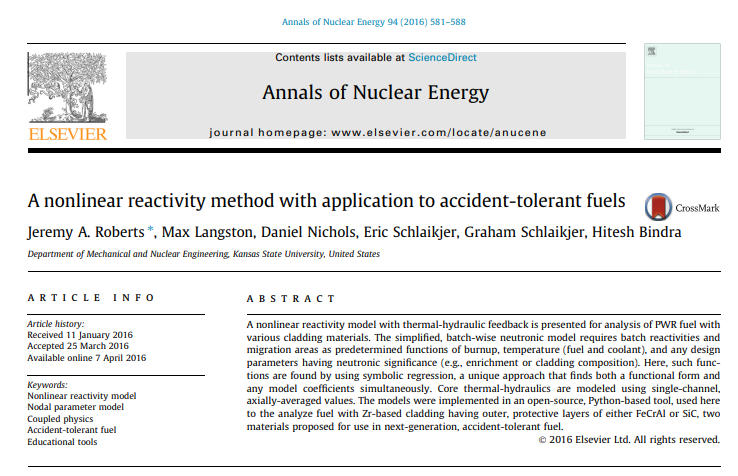

For a traditional PWR fuel, the following reactivity model was produced:

In [9]:
import numpy as np
atan2 = np.arctan2 

# Default rho from NRM
def rho_base(B, T_F=1200, T_C=600, C_B=0) :
    return 0.265701782943972 + \
           0.0173604082545277*atan2(0.0173604082545277, abs(B)**0.5) - \
           2.64479010825198e-5*T_F - \
           0.00319948157566795*B - 5.72926698137041e-6*B*T_C  

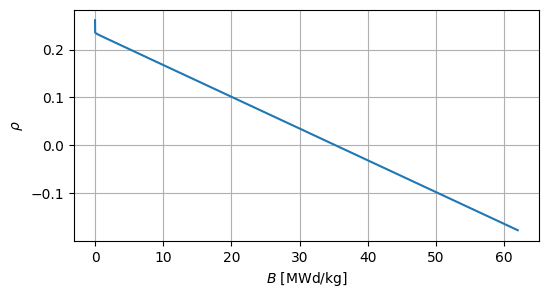

In [12]:
import matplotlib.pyplot as plt
B_vals = np.linspace(0, 62, 1000000)
plt.figure(figsize=(6, 3))
plt.plot(B_vals, rho_base(B_vals))
plt.grid(True)
#plt.xlim(0, 0.02); plt.ylim(0.22, 0.27)
plt.xlabel('$B$ [MWd/kg]'); plt.ylabel(r'$\rho$');

## Example 4

Using the grid lines to guide you, at what burnup does the reactivity go subcritical?  

# The Linear Reactivity Model

The **linear reactivity model** is based on three assumptions

**Assumption 1**: a reactor core is fueled with $N$ batches of identical fuel.

**Some nomenclature by example**: 

Suppose that $N = 3$. When a reactor like Wolf Creek is refueled, one third of the core is replaced with fresh fuel, one third is "once burned", and one third is "twice burned".  The fuel that is removed from the core is "thrice burned".  

We say the reactor is at its **beginning of cycle (BOC)** after refueling and at its **end of cycle (EOC)** before refueling.  The EOC occurs when the core has no excess reactivity.

The burnup $B_c$ that takes us from the BOC to the EOC is called the **cycle length**.  The burnup of the "thrice burned" fuel is equal to burnup accumulated over all 3 cycles and is called the **discharge burnup** or $B_d$.

**Assumption 2**: the fuel reactivity is linear with burnup: 

$$
\boxed{\rho_{\infty}(B) = \rho_0 - AB}
\tag{Eq. 1}
$$ 

The $\infty$ indicates that the reactivity is computed for an infinite reactor, e.g., the reflected unit cells that we've been using in OpenMC.  Leakage effects are accounted for later.

**Assumption 3**: the core reactivity is a weighted sum of the batch reactivities minus a penalty for leakage: 

$$
\boxed{\rho_{core} = \sum^N_{i=1} w_i \rho_i - \rho_{L}} \qquad \text{where} \, \sum_{i=1}^N w_i = 1 \, .
\tag{Eq. 2}
$$


The *simplest* LRM sets $w_i = 1/N$.  

# Using LRM to Determine $B_c$ and $B_d$

The primary use of LRM is to determine the **cycle length** and **discharge burnup** for $N$-batch cores.

## Example 5

Refer back to example 4 and write down a linear model for the fuel reactivity.  Then, assume $N=2$, $\rho_L=0.05$, and $B_c = 10$ GWd/MTU.  What is the **core** reactivity at 0 and 10 GWd/MTU? Is this cycle well designed?

$\rho(B) = \rho_0 - A  B \qquad A = (-0.1 - 0.1)/(50-20) \approx 0.00667$

$\rho(20) = 0.1 = \rho_0 - (0.00667)10 \rightarrow \rho_0 = 0.233333$

$\rho_{core}^{BOC} = \frac{1}{2} ( [\rho_0 - A\cdot 0] + [\rho_0 - A\cdot 10]) = 0.2 - 0.05 = 0.15$

$\rho_{core}^{EOC} = \frac{1}{2} ( [\rho_0 - A\cdot 10] + [\rho_0 - A\cdot 20]) = 0.13 - 0.05 = 0.08$

## Example 6

For Example 5, determine the cycle length and discharge burnup for the two-batch core.  How do these values compare to a single-batch core?

In [19]:
A = (-0.1-0.1)/(50-20)
rho0 = 0.23333

B_c = -(2/(3*A))*(rho0-0.05)
B_c
B_d = 2*B_c
B_d

36.666

More generally, the EOC reactivity of each batch in an $N$-batch core is

$$
 \begin{split}
  \rho_1 &= \rho_0 -  AB_c \\
  \rho_2 &= \rho_0 - 2AB_c \\
         & \vdots \\
  \rho_N &= \rho_0 - NAB_c \, ,
 \end{split}
$$

and the core EOC reactivity is 

$$
  \rho_{core} = \frac{1}{N} [ N\rho_0 - (A + 2A + \ldots + NA)B_c ] - \rho_L = 0
$$

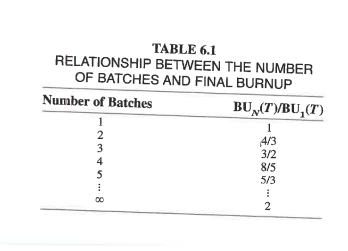

Here, BU$_N$(T) is our $B_d = N B_c$